In [1]:
# !cd github & git clone https://github.com/mwydmuch/ViZDoom

In [2]:
import random 
import time 
import numpy as np 
import cv2
import os 

from vizdoom import * 
from gym import Env 
from gym.spaces import Discrete, Box
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib import pyplot as plt 
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [3]:
game = DoomGame() 
game.load_config('./github/ViZDoom/scenarios/basic.cfg')
game.init()

In [4]:
actions = np.identity(3, dtype=np.uint8)
actions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [5]:
state = game.get_state()

In [6]:
state.game_variables

array([50.])

In [7]:
episodes = 2 
for episode in range(episodes):
    game.new_episode() 
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer 
        info = state.game_variables 
        reward = game.make_action(random.choice(actions), 4)
        print('Reward:', reward)
        time.sleep(0.1)
    print('Result:', game.get_total_reward())
    time.sleep(2)

Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: 99.0
Result: 67.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -9.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: -4.0
Reward: 98.0
Result: -86.0


In [8]:
game.close()

In [9]:
state.screen_buffer.shape

(3, 240, 320)

In [10]:
class VizDoom(Env):
    def __init__(self, render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config('./github/ViZDoom/scenarios/basic.cfg')
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(3)
        
    def step(self, action):
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4)
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo 
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {'info': info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info
    
    def render():
        pass 
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer 
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state 
    
    def close(self):
        self.game.close()

In [11]:
env = VizDoom(render=True)

In [12]:
state = env.reset()

In [13]:
env_checker.check_env(env)

In [14]:
env.close()

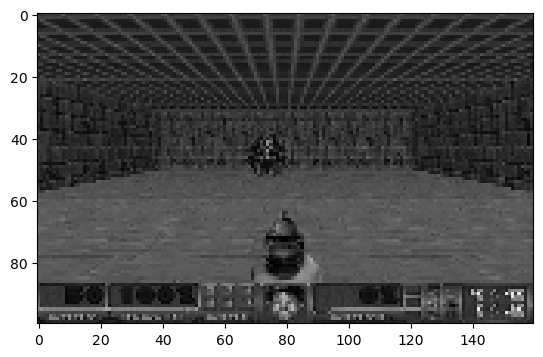

In [15]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
class TrainingAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainingAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq 
        self.save_path = save_path 
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [17]:
CHECKPOINT_DIR = './train/checkpoints'
LOG_DIR = './train/logs'

In [18]:
callback = TrainingAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [19]:
env = VizDoom()

In [20]:
model = PPO('CnnPolicy', env, verbose=1, learning_rate=0.0001, n_steps=512)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [21]:
model.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.2     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 41       |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 38.1        |
|    ep_rew_mean          | -123        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 39          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.014509393 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.000179    |
|    learning_rate        | 0.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.8         |
|    ep_rew_mean          | -60.3        |
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 11           |
|    time_elapsed         | 300          |
|    total_timesteps      | 5632         |
| train/                  |              |
|    approx_kl            | 0.0069212914 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0.479        |
|    learning_rate        | 0.0001       |
|    loss                 | 1.51e+03     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00358     |
|    value_loss           | 3.21e+03     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.2        |
|    ep_rew_mean          | -55.9       |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 21          |
|    time_elapsed         | 593         |
|    total_timesteps      | 10752       |
| train/                  |             |
|    approx_kl            | 0.010737281 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.797      |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.0001      |
|    loss                 | 1.56e+03    |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00319     |
|    value_loss           | 2.84e+03    |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 28.6    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.4        |
|    ep_rew_mean          | -23.8       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 31          |
|    time_elapsed         | 904         |
|    total_timesteps      | 15872       |
| train/                  |             |
|    approx_kl            | 0.011555146 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0001      |
|    loss                 | 1.48e+03    |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.00554     |
|    value_loss           | 2.32e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19.5  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.8        |
|    ep_rew_mean          | -23.1       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 41          |
|    time_elapsed         | 1188        |
|    total_timesteps      | 20992       |
| train/                  |             |
|    approx_kl            | 0.007351174 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.63       |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.0001      |
|    loss                 | 844         |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00201     |
|    value_loss           | 2.06e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 17.4  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.2        |
|    ep_rew_mean          | -47.1       |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 51          |
|    time_elapsed         | 1444        |
|    total_timesteps      | 26112       |
| train/                  |             |
|    approx_kl            | 0.025892084 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.766      |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.0001      |
|    loss                 | 502         |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.00611     |
|    value_loss           | 1.38e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20.8  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.13       |
|    ep_rew_mean          | 63.8       |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 61         |
|    time_elapsed         | 1702       |
|    total_timesteps      | 31232      |
| train/                  |            |
|    approx_kl            | 0.04793851 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.631     |
|    explained_variance   | 0.536      |
|    learning_rate        | 0.0001     |
|    loss                 | 271        |
|    n_updates            | 600        |
|    policy_gradient_loss | 0.0116     |
|    value_loss           | 764        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.34        |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.12         |
|    ep_rew_mean          | 80.4         |
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 71           |
|    time_elapsed         | 1977         |
|    total_timesteps      | 36352        |
| train/                  |              |
|    approx_kl            | 0.0104241455 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.395       |
|    explained_variance   | 0.318        |
|    learning_rate        | 0.0001       |
|    loss                 | 162          |
|    n_updates            | 700          |
|    policy_gradient_loss | 0.0142       |
|    value_loss           | 176          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.45        |
|    ep_rew_mean          | 84.5        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 81          |
|    time_elapsed         | 2267        |
|    total_timesteps      | 41472       |
| train/                  |             |
|    approx_kl            | 0.014054079 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.542       |
|    learning_rate        | 0.0001      |
|    loss                 | 30.2        |
|    n_updates            | 800         |
|    policy_gradient_loss | 0.00303     |
|    value_loss           | 102         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.26

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.89        |
|    ep_rew_mean          | 83          |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 91          |
|    time_elapsed         | 2550        |
|    total_timesteps      | 46592       |
| train/                  |             |
|    approx_kl            | 0.012171786 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.0001      |
|    loss                 | 18.5        |
|    n_updates            | 900         |
|    policy_gradient_loss | 0.0106      |
|    value_loss           | 59.3        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.82  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.22       |
|    ep_rew_mean          | 85.7       |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 101        |
|    time_elapsed         | 2838       |
|    total_timesteps      | 51712      |
| train/                  |            |
|    approx_kl            | 0.01413665 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.723      |
|    learning_rate        | 0.0001     |
|    loss                 | 91.8       |
|    n_updates            | 1000       |
|    policy_gradient_loss | 0.0131     |
|    value_loss           | 212        |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.99        |
|    ep_rew_m

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.99       |
|    ep_rew_mean          | 86.9       |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 111        |
|    time_elapsed         | 3118       |
|    total_timesteps      | 56832      |
| train/                  |            |
|    approx_kl            | 0.02686176 |
|    clip_fraction        | 0.0775     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.0001     |
|    loss                 | 13         |
|    n_updates            | 1100       |
|    policy_gradient_loss | 0.0107     |
|    value_loss           | 23.4       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.12        |
|    ep_rew_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.62        |
|    ep_rew_mean          | 83.7        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 121         |
|    time_elapsed         | 3378        |
|    total_timesteps      | 61952       |
| train/                  |             |
|    approx_kl            | 0.030255407 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.0001      |
|    loss                 | 33.1        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00945    |
|    value_loss           | 53.7        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.67

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.84        |
|    ep_rew_mean          | 87.4        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 131         |
|    time_elapsed         | 3634        |
|    total_timesteps      | 67072       |
| train/                  |             |
|    approx_kl            | 0.012065144 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.135      |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0001      |
|    loss                 | 6.3         |
|    n_updates            | 1300        |
|    policy_gradient_loss | 0.00945     |
|    value_loss           | 12.2        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.29  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.48        |
|    ep_rew_mean          | 84.2        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 141         |
|    time_elapsed         | 3892        |
|    total_timesteps      | 72192       |
| train/                  |             |
|    approx_kl            | 0.018055385 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.109      |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.0001      |
|    loss                 | 14.5        |
|    n_updates            | 1400        |
|    policy_gradient_loss | 0.00177     |
|    value_loss           | 70.8        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.02

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | 86.8         |
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 151          |
|    time_elapsed         | 4157         |
|    total_timesteps      | 77312        |
| train/                  |              |
|    approx_kl            | 0.0038637798 |
|    clip_fraction        | 0.0352       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.108       |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0001       |
|    loss                 | 5.36         |
|    n_updates            | 1500         |
|    policy_gradient_loss | 0.00676      |
|    value_loss           | 11.2         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.7         |
|    ep_rew_mean          | 88          |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 161         |
|    time_elapsed         | 4420        |
|    total_timesteps      | 82432       |
| train/                  |             |
|    approx_kl            | 0.036576577 |
|    clip_fraction        | 0.0805      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0982     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0001      |
|    loss                 | 8.73        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.00346    |
|    value_loss           | 24.1        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.65  

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.35       |
|    ep_rew_mean          | 85.5       |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 171        |
|    time_elapsed         | 4674       |
|    total_timesteps      | 87552      |
| train/                  |            |
|    approx_kl            | 0.01452254 |
|    clip_fraction        | 0.0572     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0955    |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.0001     |
|    loss                 | 14.5       |
|    n_updates            | 1700       |
|    policy_gradient_loss | 0.00404    |
|    value_loss           | 38.6       |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4.36         |
|    ep_re

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.87        |
|    ep_rew_mean          | 87.3        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 181         |
|    time_elapsed         | 4929        |
|    total_timesteps      | 92672       |
| train/                  |             |
|    approx_kl            | 0.028891608 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0868     |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.0001      |
|    loss                 | 20.3        |
|    n_updates            | 1800        |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 29.2        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 4.19    

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.88        |
|    ep_rew_mean          | 87.2        |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 191         |
|    time_elapsed         | 5188        |
|    total_timesteps      | 97792       |
| train/                  |             |
|    approx_kl            | 0.004201682 |
|    clip_fraction        | 0.057       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.125      |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.0001      |
|    loss                 | 8.89        |
|    n_updates            | 1900        |
|    policy_gradient_loss | 0.00497     |
|    value_loss           | 32.8        |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 4.35      

In [22]:
# model.load('./models/Basic100k')

In [23]:
model.save('./models/VizDoom_Basic')

In [24]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\86183\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [25]:
mean_reward

85.8

In [26]:
for episode in range(10):
    obs = env.reset()
    done = False 
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward 
    print('Total reward for episode {} is {}'.format( episode + 1, total_reward))
    time.sleep(2)

Total reward for episode 1 is 67.0
Total reward for episode 2 is 95.0
Total reward for episode 3 is 75.0
Total reward for episode 4 is 95.0
Total reward for episode 5 is 95.0
Total reward for episode 6 is 95.0
Total reward for episode 7 is 95.0
Total reward for episode 8 is 95.0
Total reward for episode 9 is 95.0
Total reward for episode 10 is 75.0
